In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from mnist import MNIST
from sklearn import manifold
import numpy as np
from time import time
import os
from matplotlib import offsetbox
from torch.utils.tensorboard import SummaryWriter

In [ ]:
mndata = MNIST('Data/mnist')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

In [ ]:
X_tr = np.array(train_images)
y_tr = np.array(train_labels)
X_te = np.array(test_images)
y_te = np.array(test_labels)

In [ ]:
img_tr = X_tr.reshape([-1, 1,28,28])
img_te = X_te.reshape([-1, 1,28,28])
print(img_tr.shape)
print(img_te.shape)

In [ ]:
import pandas as pd
df_te = pd.Series(y_te)
df_tr = pd.Series(y_tr)
print(df_te.value_counts())
print(df_tr.value_counts())

In [ ]:
# X_tr = X_tr.reshape([-1, 28, 28])
img_tr.shape

In [17]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, img, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    # if hasattr(offsetbox, 'AnnotationBbox'):
    #     # only print thumbnails with matplotlib > 1.0
    #     shown_images = np.array([[1., 1.]])  # just something big
    #     for i in range(X.shape[0]):
    #         dist = np.sum((X[i] - shown_images) ** 2, 1)
            # if np.min(dist) < 4e-1:
            #     # don't show points that are too close
            #     continue
            # shown_images = np.r_[shown_images, [X[i]]]
            # imagebox = offsetbox.AnnotationBbox(
            #     offsetbox.OffsetImage(img[i], cmap=plt.cm.gray_r),
            #     X[i])
            # ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing t-SNE embedding
1.5323798656463623


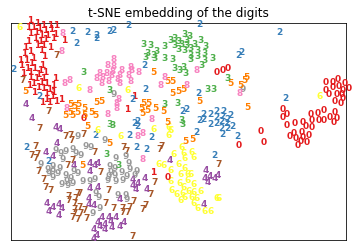

In [20]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
N = 500
s = time()
X_tsne = tsne.fit_transform(X_tr[:N])
print(time() - s)

plot_embedding(X_tsne, y_tr[:N], img_te.reshape([-1, 28,28,1]),
               "t-SNE embedding of the digits")

Computing t-SNE embedding


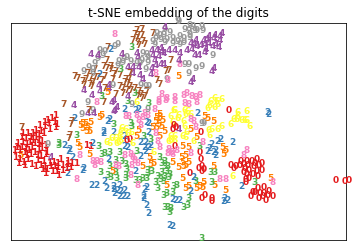

In [39]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
N = 700
X = X_te
Y = y_te
rand_idx = np.random.randint(len(X), size=N)

# print(Y[rand_idx])
# print(rand_idx)
# print(Y[:500])

X_tsne = tsne.fit_transform(X[:N])

plot_embedding(X_tsne, Y[:N], img_te.reshape([-1, 28,28,1]),
               "t-SNE embedding of the digits")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d( 1,  8, 3, stride=2,padding=1) #28x28x1 -> 14x14x8
        self.conv2 = nn.Conv2d( 8, 16, 3, stride=2,padding=1) #14x14x8 -> 7x7x16
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2) #7x7x16 -> 3x3x32
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1) #3x3x32 -> 1x1x32
        self.fc1   = nn.Linear(32, 10)
        
        #Decoder
        self.t_fc1   = nn.Linear(10, 32) # [32]
        self.t_conv1 = nn.ConvTranspose2d(32, 32, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16,  8, 3, stride=2, padding=1)
        self.t_conv4 = nn.ConvTranspose2d(8,   1, 3, stride=2, output_padding=1)
    
    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))        
        x = F.relu(self.conv3(x))        
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        return x
    
    def decoder(self, x):
        x = F.relu(self.t_fc1(x)) # 10 -> 32
        x = x.reshape([-1,32,1,1])
        x = F.relu(self.t_conv1(x)) # [m, 1,1,32] -> [m, 3,3,32]
        x = F.relu(self.t_conv2(x)) # [m, 3,3,32] -> [m, 7,7,16]
        x = F.relu(self.t_conv3(x)) # [m, 7,7,16] -> 
        x = F.relu(self.t_conv4(x))
        return x                    #[m, 1, 28, 28]
    
    def forward(self, x):
        latent_vector    = self.encoder(x)
        predicted_output = self.decoder(latent_vector)
        return predicted_output
        

In [ ]:
model = AutoEncoder()

In [ ]:
r = torch.randn(5, 1, 28, 28)
rout = model.encoder(r)
rout.shape

In [ ]:
model.decoder(rout).shape

In [ ]:
model.forward(r).shape

In [ ]:
img_tr_tensor = torch.tensor(img_tr)/255.0 #converting from 0-255 to 0.0-1.0
y_tr_tensor   = torch.tensor(y_tr)
img_te_tensor = torch.tensor(img_te)/255.0 #converting from 0-255 to 0.0-1.0
y_te_tensor   = torch.tensor(y_te)

train_dataset = torch.utils.data.TensorDataset(img_tr_tensor, y_tr_tensor)
test_dataset  = torch.utils.data.TensorDataset(img_te_tensor, y_te_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=10, num_workers=0)

In [ ]:
loss_fxn  = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
save_dir  = "./checkpoints/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
writer    = SummaryWriter('runs/exp_1')
te_writer = SummaryWriter('runs/test_1')

In [ ]:
try:
    load_ckpt_num = 19
    checkpoint = torch.load(save_dir+"/ep_{}.ckpt".format(load_ckpt_num))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    global_epoch = checkpoint['global_epoch']
    print("loaded global ep: {}".format(global_epoch))
except Exception as e:
    print("Loading checkpoint failed! - {}".format(e))
    global_epoch = 0
    
n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0.0
    model.train()
    for data in train_loader:
        images, _ = data
        outputs = model.forward(images)
        loss = loss_fxn(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss+=(loss.item()*images.size(0))
           
    if(epoch%5==4):
        print("Saving Global epoch: {}".format(global_epoch))
        
        torch.save({
            'global_epoch':global_epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()
        }, save_dir+"/ep_{}.ckpt".format(global_epoch))
        
        writer.add_scalar('train_loss', train_loss/len(train_loader), global_epoch)
        
        model.eval()
        with torch.no_grad():
            te_loss = 0.0
            for te_data in test_loader:
                te_imgs, _ = data
                te_out = model.forward(te_imgs)
                loss_ = loss_fxn(te_out, te_imgs)
                te_loss += loss_.item() * te_imgs.size(0)
            te_loss = te_loss/len(test_loader)
            te_writer.add_scalar('test_loss', te_loss, global_epoch)

            print("Test Loss: {}".format(te_loss))
    
    
    global_epoch+=1 
    
    train_loss = train_loss/len(train_loader)
    print("Epoch: {} \t Training Loss: {}".format(epoch, train_loss))

In [ ]:
writer.add_graph(model, images)
# writer.close()

In [ ]:
y_pred = model.forward(img_te_tensor[18:19])[0]
y_pred.shape
temp = y_pred.permute(1,2,0).detach().numpy()
print(temp.shape)
# print(y_pred)
# type(y_pred)
plt.imshow(temp)
plt.show()

In [ ]:
def display_img(tensor):
    m = tensor.shape[0]
    for i in range(m):
        temp = tensor[i].permute(1,2,0).detach().numpy()
        plt.imshow(temp)
        plt.show()

In [ ]:
# Generating a random latent vector.
# Generated image in random!!
lat = torch.randn([2, 10])
print(lat.shape)
out = model.decoder(lat)
print(out.shape)
print(out.shape[0])
display_img(out)

In [ ]:
l1 = model.encoder(img_te_tensor[171:172])
l2 = model.encoder(img_te_tensor[1325:1326])
l_avg = (l1+l2)/2

o1 = model.decoder(l1)
o2 = model.decoder(l2)
o3 = model.decoder(l_avg)

display_img(o1)
display_img(o2)
display_img(o3)